#Ze Meng

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as date

In [3]:
import os
os.getcwd()
os.chdir("C:\\Users\\Ze Meng\\OneDrive - Michigan State University\\Documents\\2019MSU Spring")

This data is stock price data from Microsoft, each obervation is a weekly price of microsoft, range from 2017-04-24 to 
2019-04-22. The data is collected on Yahoo Finance website.

In [4]:
df = pd.read_csv("MSFT_1.csv")

In [5]:
#Preprocessing the dataset
df.dropna(inplace = True)
df.loc[:,'Date'] = pd.to_datetime(df.loc[:,'Date'], format="%Y/%m/%d",)
df.drop('Open High Low Volume'.split(), axis=1, inplace=True)
df.drop('Adj Close',axis=1,inplace=True)
df.set_index('Date',inplace=True)
df.head(5)

,Close
Date,
2017-04-24,68.459999
2017-05-01,69.000000
2017-05-08,68.379997
2017-05-15,67.690002
2017-05-22,69.959999


In [6]:
#split the dataset
from sklearn.model_selection import train_test_split

In [7]:
df_train, df_valid = train_test_split(df, train_size = 0.8, shuffle=False)

Plot the data, we can obviously a trend, which also tells us the data is not stationary.

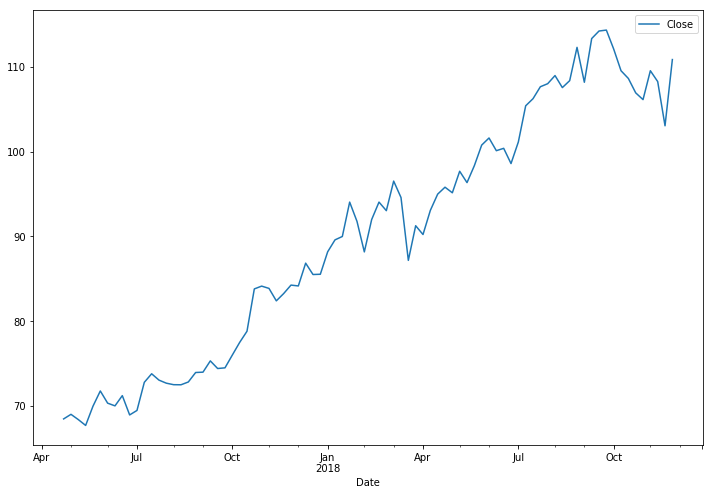

In [8]:
df_train.plot(figsize=(12,8))

In [9]:
df_train.shift(-1).head(5)

,Close
Date,
2017-04-24,69.000000
2017-05-01,68.379997
2017-05-08,67.690002
2017-05-15,69.959999
2017-05-22,71.760002


In [10]:
#Difference the stock price and make it stationary
df1_train = df_train - df_train.shift(-1)
df1_train.dropna(inplace=True)

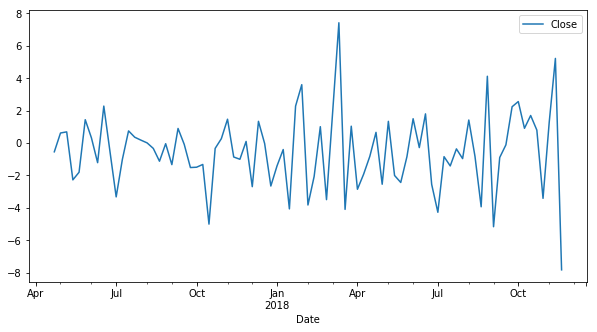

In [11]:
df1_train.plot(figsize = (10,5))

In [12]:
#test stationarity
print('Results of Dickey-Fuller Test:')
dftest = sm.tsa.adfuller(df1_train['Close'])
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -4.044185
p-value                         0.001196
#Lags Used                      5.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


Plot acf and pacf, we can roughly guess the order of ARMA process, from the plot we guess p=5 and q=1

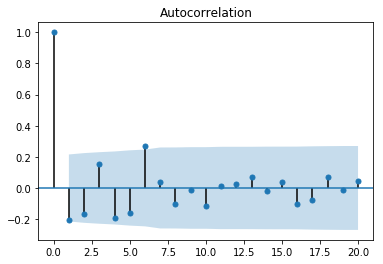

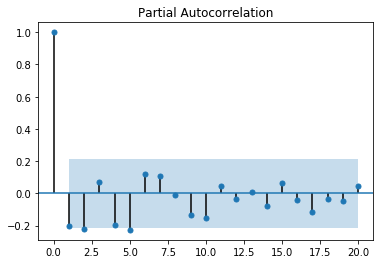

In [13]:
acf = sm.tsa.graphics.plot_acf(df1_train['Close'], lags=20)
pacf = sm.tsa.graphics.plot_pacf(df1_train['Close'], lags=20)

In [14]:
#By selecting aic as criteria, decide the order.
sm.tsa.stattools.arma_order_select_ic(df1_train['Close'], ic='aic')

{'aic':             0           1           2
 0  381.036954  377.034466  376.515913
 1  379.101588  374.717374  377.893279
 2  376.902122  377.625455  371.975181
 3  378.093712  379.462262  377.404599
 4  376.266358  376.568414  367.783589, 'aic_min_order': (4, 2)}

In [15]:
#fit the model_1
mod = sm.tsa.ARIMA(df_train, order = (4,1,2), freq='W')
result = mod.fit()
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                   83
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -175.892
Method:                       css-mle   S.D. of innovations              1.985
Date:                Fri, 03 May 2019   AIC                            367.784
Time:                        23:41:44   BIC                            387.134
Sample:                    05-01-2017   HQIC                           375.558
                         - 11-26-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4872      0.163      2.995      0.004       0.168       0.806
ar.L1.D.Close    -0.0839      0.176     -0.477      0.635      -0.428       0.261
ar.L2.D.Close    -0.8940      0.191     

In [16]:
#fit the model_2
mod1 = sm.tsa.ARIMA(df_train, order = (2,1,2), freq='W')
result1 = mod1.fit()
print(result1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                   83
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -179.988
Method:                       css-mle   S.D. of innovations              2.053
Date:                Fri, 03 May 2019   AIC                            371.975
Time:                        23:41:47   BIC                            386.488
Sample:                    05-01-2017   HQIC                           377.806
                         - 11-26-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4889      0.227      2.157      0.034       0.045       0.933
ar.L1.D.Close    -0.1964      0.086     -2.273      0.026      -0.366      -0.027
ar.L2.D.Close    -0.7412      0.093     

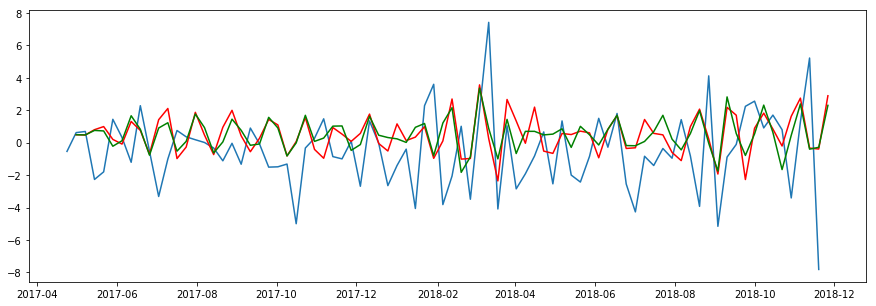

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df1_train)
plt.plot(result.fittedvalues, color='red')
plt.plot(result1.fittedvalues, color='green')
plt.show()

In [18]:
#take back to original scale
df_estimated = pd.DataFrame(result.fittedvalues,columns=['Close'],copy=False)
df_origin = df_estimated['Close'] + df_train['Close']
df_origin.dropna(inplace=True)

In [19]:
#take back to original scale model_2
df1_estimated = pd.DataFrame(result1.fittedvalues,columns=['Close'],copy=False)
df1_origin = df1_estimated['Close'] + df_train['Close']
df1_origin.dropna(inplace=True)

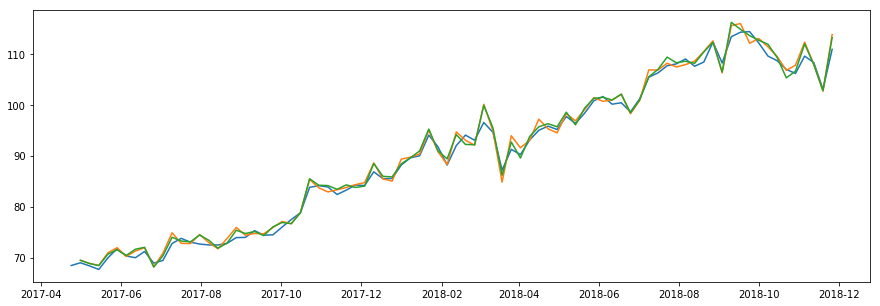

In [20]:
plt.figure(figsize=(15,5))
plt.plot(df_train['Close'])
plt.plot(df_origin)
plt.plot(df1_origin)
plt.show()

In [21]:
#make predictions and compared it to the validation dataset
forecast = pd.DataFrame(result.forecast(len(df_valid['Close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

In [22]:
#make predictions and compared it to the validation dataset
forecast1 = pd.DataFrame(result1.forecast(len(df_valid['Close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

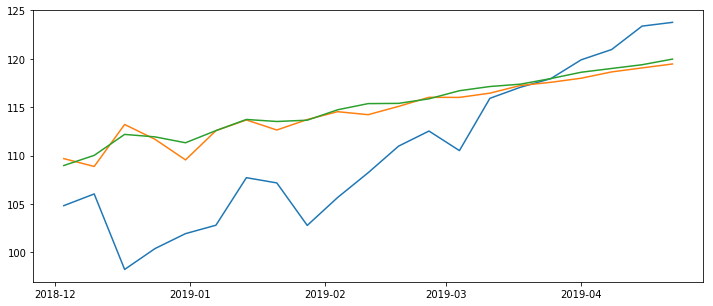

In [23]:
plt.figure(figsize=(12,5))
plt.plot(df_valid['Close'])
plt.plot(forecast['forecasted values'])
plt.plot(forecast1['forecasted values'])
plt.show()

We take the predicted Noise back to the original scale, we find it fits the existed plot well in some degree, however
the performance of forecasted result is not as good as training dataset, which is normal. Compared the result with validation dataset, we find that the forecasting is optimistic at the beginning and the predicted increasing is conservative after February.

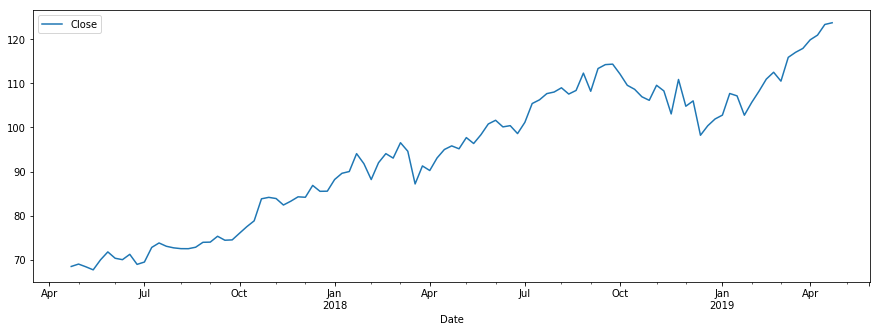

In [26]:
df.plot(figsize=(15,5))

In [28]:
df_diff = df - df.shift(-1)
df_diff.dropna(inplace = True)

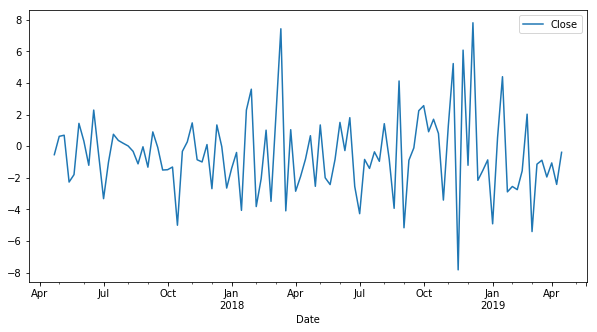

In [29]:
df_diff.plot(figsize=(10,5))

In [24]:
#fit the model to the whole dataset
model_final = sm.tsa.ARIMA(df, order = (4,1,2), freq = 'W')
result_final = model_final.fit()
print(result_final.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  104
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -233.745
Method:                       css-mle   S.D. of innovations              2.234
Date:                Fri, 03 May 2019   AIC                            483.491
Time:                        23:44:05   BIC                            504.646
Sample:                    05-01-2017   HQIC                           492.061
                         - 04-22-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5328      0.172      3.103      0.003       0.196       0.869
ar.L1.D.Close    -0.0863      0.100     -0.863      0.390      -0.282       0.110
ar.L2.D.Close    -0.8483      0.095     

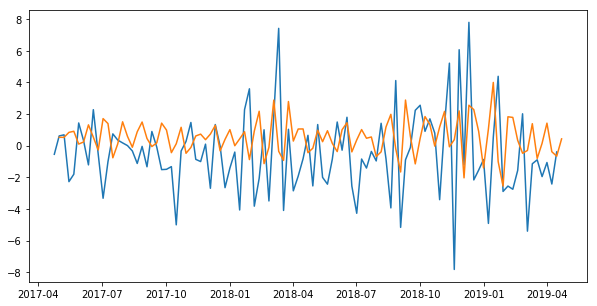

In [31]:
plt.figure(figsize=(10,5))
plt.plot(df_diff)
plt.plot(result_final.fittedvalues)
plt.show()

In [32]:
df_estimated_final = pd.DataFrame(result_final.fittedvalues,columns=['Close'],copy=False)
df_origin_final = df_estimated_final['Close'] + df['Close']
df_origin_final.dropna(inplace=True)

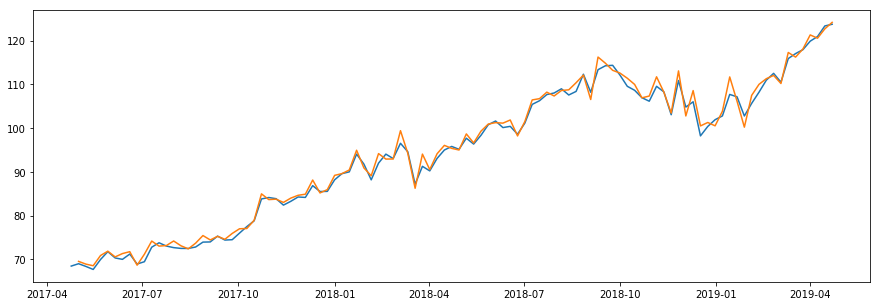

In [33]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.plot(df_origin_final)
plt.show()

In [35]:
result_forecast = ['2019-04-29', '2019-05-06','2019-05-13']
result_forecast_index = pd.to_datetime(result_forecast)

In [36]:
result_forecast_index

DatetimeIndex(['2019-04-29', '2019-05-06', '2019-05-13'], dtype='datetime64[ns]', freq=None)

In [39]:
forecast_final = pd.DataFrame(result_final.forecast(steps=3)[0], columns= ['forcasetd values'], index=result_forecast_index)

In [40]:
forecast_final['forcasetd values']

2019-04-29    125.407939
2019-05-06    125.482212
2019-05-13    124.743645
Name: forcasetd values, dtype: float64

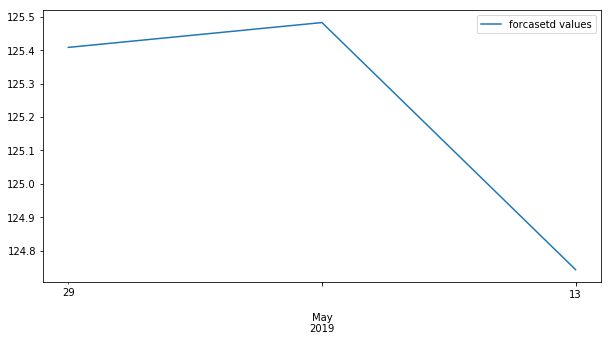

In [41]:
forecast_final.plot(figsize=(10,5))